In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc
from code.generate_data import SinteticData
from code.representation import *
from code.utils import *
from code.learning_models import *
from code.baseline import RaykarMC,LabelInference
from code.MixtureofGroups import GroupMixtureOpt

import matplotlib
font = {'family' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

matplotlib.rc('axes', titlesize=25)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=25)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

to_check = [100,2000,5000,10000,15000,25000,40000]
to_check

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[100, 2000, 5000, 10000, 15000, 25000, 40000]

100
2000
5000
10000
15000
25000
CIFAR example 50k exaples, 10 classes


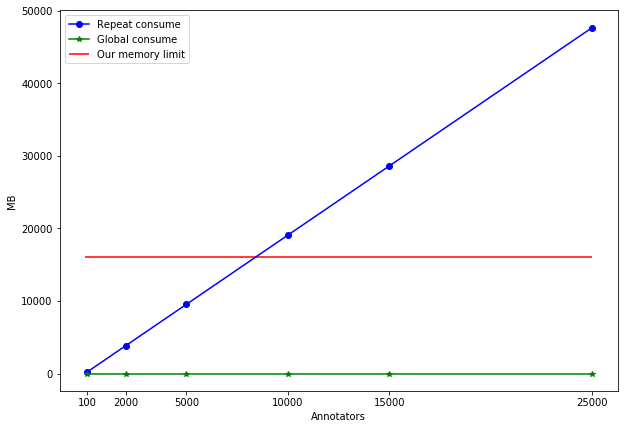

In [6]:
memory_cons = []
N = 50000
K = 10
for t in to_check:
    print(t)
    a = np.zeros((N,t,K),dtype='float32') #int8
    memory_cons.append(a.nbytes/(1024*1024)) #MB

plt.figure(figsize=(10,7))
ours_consume = np.zeros((N,K),dtype='float32').nbytes/(1024*1024)
print("CIFAR example 50k exaples, 10 classes")
plt.plot(to_check,memory_cons,'bo-',label="Repeat consume")
#plt.hlines(ours_consume,0,25000, 'g' , label="Global consume")
plt.plot(to_check,np.tile(ours_consume,len(to_check)),'g*-',label="Global consume")
plt.hlines(16000,0,to_check[-1], color='r', label="Our memory limit")

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("Annotators")
plt.legend()
plt.show()

In [2]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
N = Z_train.shape[0]
GenerateData = SinteticData(state=None)

#CONFUSION MATRIX CHOOSE
GenerateData.set_probas(asfile=True,file_matrix='./synthetic/simple/matrix_datasim_normal.csv',file_groups ='./synthetic/simple/groups_datasim_normal.csv')

#GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

In [3]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [4]:
to_check = [100,2000,5000,10000,15000,25000,40000]
T_data = 10 

annot_acc = []
raykar_exec = []
raykar_init = []
ourglobal_exec = []
ourglobal_init = []
mv_exec = []
ds_exec = []
for Tmax in to_check:
    aux_annot_acc = []
    aux_raykar_exec = []
    aux_raykar_init = []
    aux_ourglobal_exec = []
    aux_ourglobal_init = []
    aux_mv_exec = []
    aux_ds_exec = []
    for _ in range(10):

        y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)

        #annot_acc.append(np.mean(GenerateData.yo_label == Z_train))

        #get representation needed for Raykar
        y_obs_categorical = set_representation(y_obs,'onehot') 

        raykarMC = RaykarMC(X_train.shape[1:],y_obs_categorical.shape[-1],Tmax,epochs=1)
        raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)
        logL_hists,i = raykarMC.multiples_run(1,X_train,y_obs_categorical,max_iter=2)

        aux_raykar_exec.append(raykarMC.current_exectime)
        aux_raykar_init.append(raykarMC.init_exectime)

        del raykarMC
        gc.collect()
        keras.backend.clear_session()

        r_obs = set_representation(y_obs,"repeat")
        gMixture_Global = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=1,pre_init=0) 
        gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
        gMixture_Global.lambda_random = True #with lambda random --necessary
        logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,max_iter=2,cluster=True)

        aux_ourglobal_exec.append(gMixture_Global.current_exectime)
        aux_ourglobal_init.append(gMixture_Global.init_exectime)
    
        del gMixture_Global
        gc.collect()
        keras.backend.clear_session()
        
        mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
        time_callback = TimeHistory()
        model_mvsoft = MLP_Keras(X_train.shape[1:],mv_soft.shape[1],16,1,BN=False,drop=0.2)
        model_mvsoft.compile(loss='categorical_crossentropy',optimizer='adam')
        model_mvsoft.fit(X_train, mv_soft, epochs=2,batch_size=64,verbose=1,callbacks=[time_callback])
        times = time_callback.times
        aux_mv_exec.append(times[-1])
        
        #AND DS???????
        label_I = LabelInference(y_obs,1e-10, type_inf = 'ds', max_iter=3)
        ds_labels,ds_conf = label_I.DS_labels()
        aux_ds_exec.append(label_I.DS_current_exectime)
        
    raykar_exec.append(np.mean(aux_raykar_exec))
    raykar_init.append(np.mean(aux_raykar_init))
    ourglobal_exec.append(np.mean(aux_ourglobal_exec))
    ourglobal_init.append(np.mean(aux_ourglobal_init))
    mv_exec.append(np.mean(aux_mv_exec))
    ds_exec.append(np.mean(aux_ds_exec))
    
raykar_exec = np.asarray(raykar_exec)
raykar_init = np.asarray(raykar_init)
ourglobal_exec = np.asarray(ourglobal_exec)
ourglobal_init = np.asarray(ourglobal_init)
mv_exec = np.asarray(mv_exec)
ds_exec = np.asarray(ds_exec)
print("Done")

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/2 
M step: done,  E step: done //  (in 1.64 sec)	logL: -18064.969	
Iter 2/2 
M step: done,  E step: done //  (in 0.15 sec)	logL: -16563.195	Tol1: 0.08313	Tol2: 0.28646	
Finished training
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.006603 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6121725  0.57657105 0.26334342 0.5951035  0.95249176]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/2
M step: done,  E step: done //  (in 1.54 sec)	logL: -24830.978	
Iter 2/2
M step: done,  E step: done //  (in 0.35 sec)	logL: -23789.535	Tol1: 0.04194	Tol2: 0.43851	Tol3: 0.06482	
Finished training!
Epoch 1/2
2457/2457 [==============================] - 0s 169us/step - loss: 1.0738
Epoch 2/2
2457/2457 [==============================] - 0s 30us/step - loss: 0.991

In [5]:
import pandas as pd
df = pd.DataFrame({"Raykar exec": raykar_exec, "Raykar init": raykar_init, "Our exec": ourglobal_exec,
                  "Our init": ourglobal_init, "MV exec": mv_exec, "DS exec": ds_exec})
df.to_csv("time_comparison.csv",index=False)
df.head()

,DS exec,MV exec,Our exec,Our init,Raykar exec,Raykar init
0,0.250600,0.079200,0.298502,0.009352,0.171685,0.010271
1,1.703965,0.067968,0.300040,0.009355,0.278917,0.170518
2,2.341949,0.067791,0.140558,0.004773,0.225573,0.282068
3,4.215937,0.069347,0.141013,0.004901,0.295861,0.479171
4,5.414651,0.068950,0.137257,0.004480,0.374893,0.638804


In [3]:
df = pd.read_csv("time_comparison.csv")
raykar_exec = df["Raykar exec"].values
raykar_init = df["Raykar init"].values
ourglobal_exec = df["Our exec"].values
ourglobal_init = df["Our init"].values
mv_exec = df["MV exec"].values
ds_exec = df["DS exec"].values

ITERATION TIME


/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


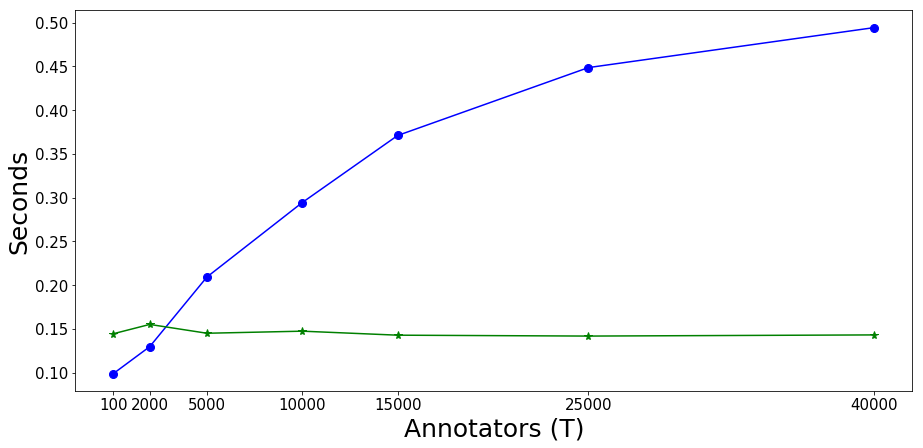

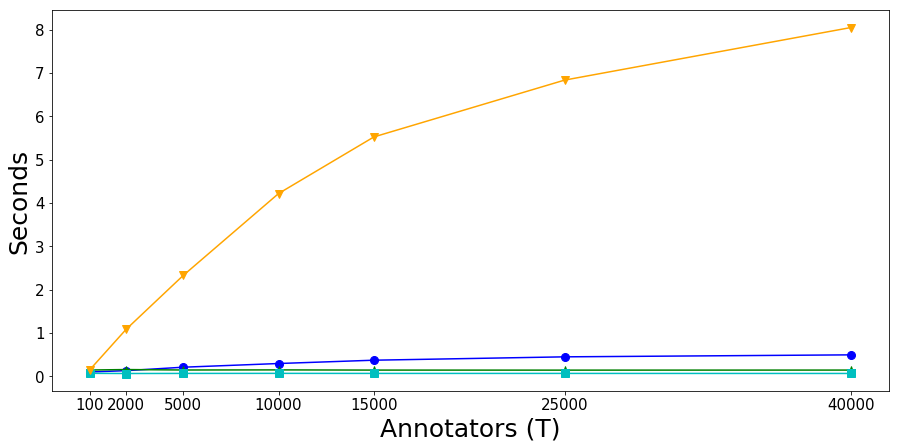

In [8]:
print("ITERATION TIME")
plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar time", markersize=8)
plt.plot(to_check,ourglobal_exec,'g*-',label="CMM time", markersize=8)
plt.xticks(to_check)

plt.ylabel("Seconds")
plt.xlabel("Annotators (T)")
#plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="Raykar time", markersize=8)
plt.plot(to_check,ourglobal_exec,'g*-',label="CMM time", markersize=8)
plt.plot(to_check,mv_exec,'cs-',label="MV time", markersize=8)
plt.plot(to_check,ds_exec,'v-',label="DS time", color='orange', markersize=8)
#plt.plot(to_check,ds_exec+mv_exec,'p-',label="DS utility iter exec", color='orange')

plt.xticks(to_check)
plt.ylabel("Seconds")
plt.xlabel("Annotators (T)")
#plt.legend()
plt.show()

INIT TIME


/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


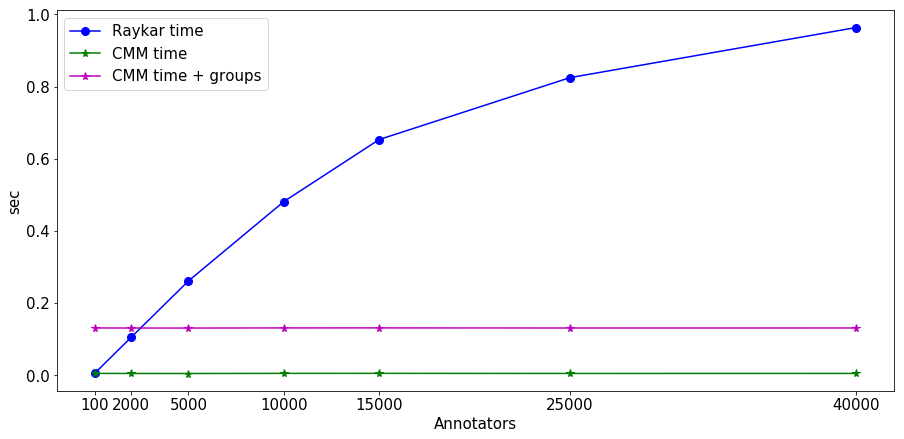

In [25]:
print("INIT TIME")

plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_init,'bo-',label="Raykar time", markersize=8)
plt.plot(to_check,ourglobal_init,'g*-',label="CMM time", markersize=8)
plt.plot(to_check,ourglobal_init+0.0021*60,'m*-',label="CMM time + groups", markersize=8) #datacenter time
#plt.plot(to_check,ourglobal_init+0.0041*60,'m*-',label="Our-Global init exec + groups")# pc-casa time
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


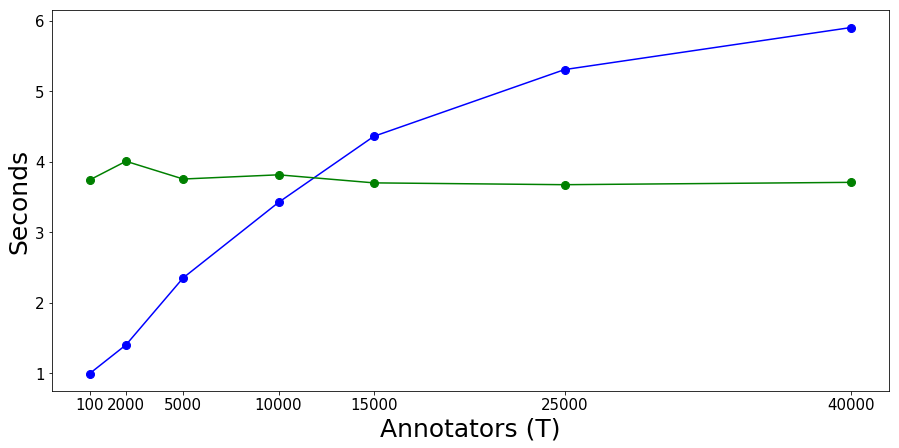

In [4]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 10
Our_iter = 25

plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'bo-',label="Raykar time", markersize=8)
#plt.plot(to_check,ourglobal_init+ourglobal_exec*Our_iter,'o-',label="Our-Global to conv")
plt.plot(to_check,ourglobal_init+0.0021*60+ourglobal_exec*Our_iter,'go-',label="CMM time", markersize=8)#datacenter
#plt.plot(to_check,ourglobal_init+0.0041*60+ourglobal_exec*Our_iter,'g*-',label="Our-Global to conv + groups")

plt.xticks(to_check)
plt.ylabel("Seconds")
plt.xlabel("Annotators (T)")
#plt.legend()
plt.show()

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


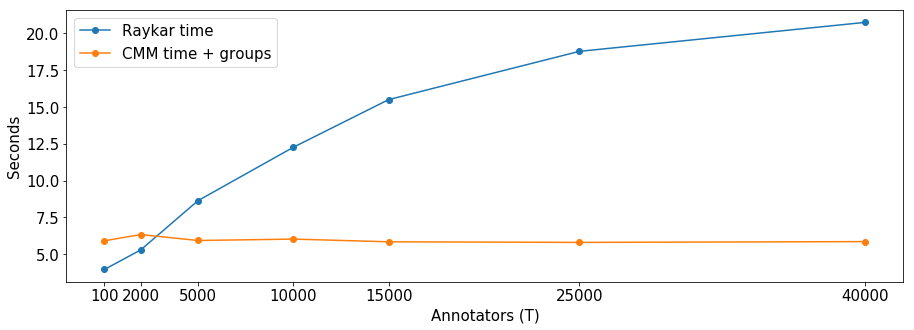

In [16]:
# falta por el numero de iteraciones (El nuestro tiene mas)
R_iter = 40
Our_iter = 40

plt.figure(figsize=(15,5))
plt.plot(to_check,raykar_init+raykar_exec*R_iter,'o-',label="Raykar time", markersize=8)
plt.plot(to_check,ourglobal_init+0.0021*60+ourglobal_exec*Our_iter,'o-',label="CMM time + groups", markersize=8)
plt.xticks(to_check)
plt.ylabel("Seconds")
plt.xlabel("Annotators (T)")
plt.legend()
plt.show()

### Future comparison
---

Simple Data


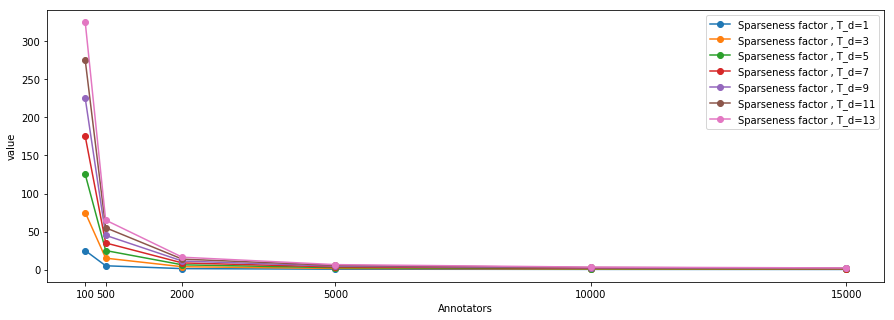

CIFAR Data


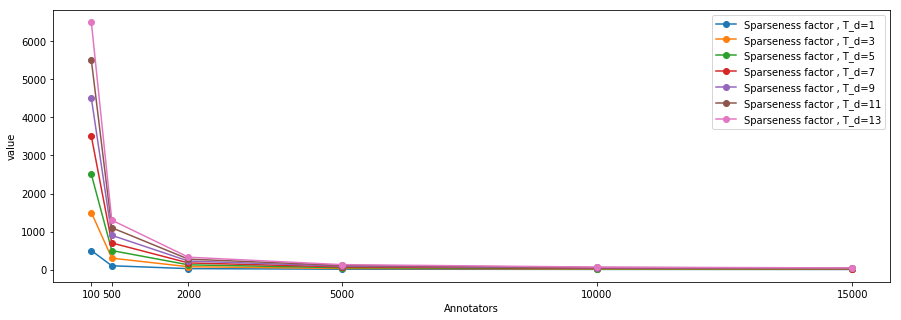

In [22]:
to_check = [100,500,2000,5000,10000,15000]
print("Simple Data")
N = 2500

T_data_test = np.arange(1,15,2)

plt.figure(figsize=(15,5))
for T_data in T_data_test:
    #fixint T_data
    D_t = [N*T_data/T for T in to_check]
    plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()

print("CIFAR Data")
N = 50000

T_data_test = np.arange(1,15,2)

plt.figure(figsize=(15,5))
for T_data in T_data_test:
    #fixint T_data
    D_t = [N*T_data/T for T in to_check]
    plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()

Simple Data


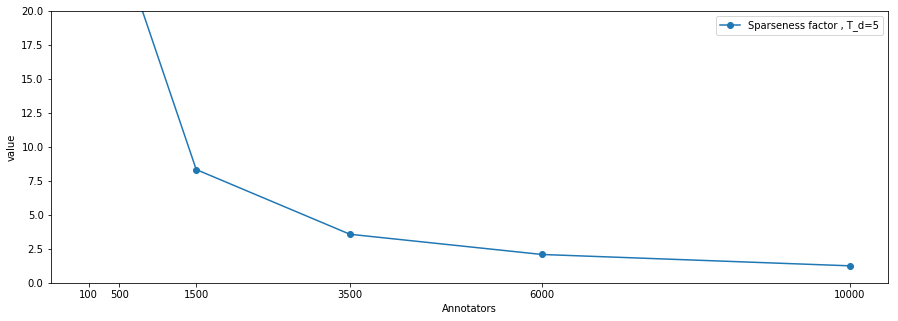

CIFAR Data


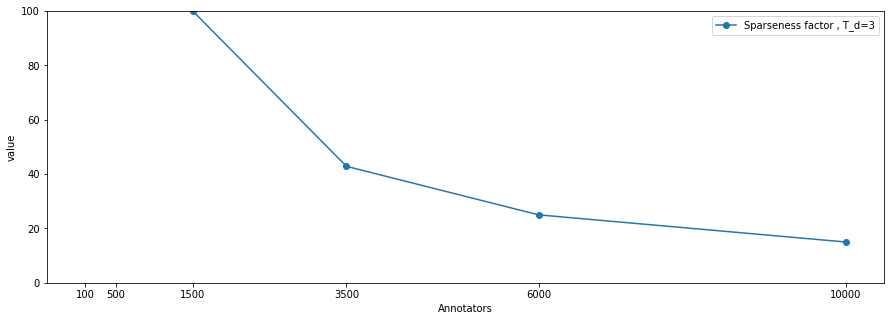

In [54]:
to_check = [100,500,1500,3500,6000,10000]
print("Simple Data")
N = 2500

plt.figure(figsize=(15,5))
T_data = 5 #5 para llegar solo a 10k o 10 para llegar a 15k
D_t = [N*T_data/T for T in to_check]
plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))    
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.ylim(0,20)

plt.show()

print("CIFAR Data")
N = 50000
T_data = 3 #para poder ver sparness factor mas bajos..
plt.figure(figsize=(15,5))
D_t = [N*T_data/T for T in to_check]
plt.plot(to_check,D_t,'o-',label="Sparseness factor , T_d="+str(T_data))
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.ylim(0,100)
plt.show()

In [46]:
np.linspace(100,10000,6)

array([  100.,  2080.,  4060.,  6040.,  8020., 10000.])

In [4]:
to_check = [25,100,500,2000,5000,10000]


T_d= 5


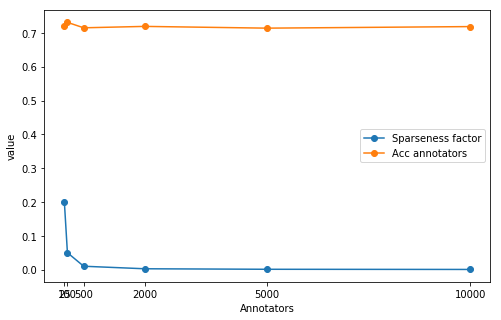

In [43]:
N = Z_train.shape[0]
#fixing T_d
T_data = 5
print("T_d=",T_data)
D_t = np.asarray([N*T_data/T for T in to_check])

annot_acc = []
for Tmax in to_check:
    aux = []
    for _ in range(10):
        y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)
        aux.append(np.mean(GenerateData.yo_label == Z_train))
    annot_acc.append(np.mean(aux))
    
plt.figure(figsize=(8,5))
plt.plot(to_check,D_t/N,'o-',label="Sparseness factor")
plt.plot(to_check,annot_acc,'o-',label="Acc annotators")
plt.xticks(to_check)
plt.ylabel("value")
plt.xlabel("Annotators")
plt.legend()
plt.show()